<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [34]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 622 (delta 69), reused 25 (delta 25), pack-reused 517 (from 3)
Receiving objects: 100% (622/622), 66.70 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (322/322), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [35]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [36]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
149,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,NaN,NaN,NaN,NaN,NaN,1.128571,1.756653,10.863785,9.008606,AAPL
152,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,-3.444626,0.245331,7.016815,0.616699,AAPL
155,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.933334,3.601639,9.637100,-0.162491,AAPL
158,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,0.873398,0.392532,8.744034,2.098389,AAPL
161,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.265976,-1.069687,9.313263,4.827057,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,2025-01-27,394.799988,406.690002,389.000000,397.149994,58125500,0.0,0.0,29723.864,4.0,...,1.174326,-0.262426,0.298183,0.182200,0.388200,0.940002,NaN,NaN,NaN,TSLA
8072,2025-01-28,396.910004,400.589996,386.500000,398.089996,48910700,0.0,0.0,29723.864,4.0,...,0.084330,-0.354550,-0.611864,-0.449780,0.584349,-8.989990,NaN,NaN,NaN,TSLA
8082,2025-01-29,395.209991,398.589996,384.480011,389.100006,68033600,0.0,0.0,29723.864,4.0,...,0.827862,-0.620100,-0.024186,-0.439615,0.781107,11.179993,NaN,NaN,NaN,TSLA
8092,2025-01-30,410.779999,412.500000,384.410004,400.279999,98092900,0.0,0.0,29723.864,4.0,...,1.383147,-0.616897,-0.145329,-0.418483,0.636253,4.320007,NaN,NaN,NaN,TSLA


In [37]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [39]:
import glob
import os

# Read articles df
csv_files = glob.glob(os.path.join(os.getcwd(), "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [30]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [32]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')

In [42]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'GDP (Billions USD)', 'Unemployment Rate (%)',
       ...
       'positive_lag1', 'positive_lag3', 'positive_lag5', 'positive_lag7',
       'positive_lag14', 'positive_lag30', 'Articles_Negative',
       'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment'],
      dtype='object', length=1079)


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [64]:
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)
df["time_idx"] = df.groupby("Ticker").cumcount()

# feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP (Billions USD)', 'Unemployment Rate (%)',
#                 'positive', 'neutral', 'negative']

feature_cols = [col for col in df.columns if 'Target' not in col and col not in ['Date', 'Ticker', 'time_idx']]

target_col = "Target_1day"

In [65]:
filtered_df = df.dropna(subset=[target_col])
scaler = StandardScaler()

X = scaler.fit_transform(filtered_df[feature_cols])
y = filtered_df[target_col].values


In [66]:
def create_sequences(X, y, look_back=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y)

In [67]:
split = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

In [68]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 17.1938
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 18.8940
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 15.9531
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 45.5939
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 60.4188
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 23.6194
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 17.0645
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 15.0235
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 14.1879
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 14.9064
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 12.3743
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 12.4401
Epoch 13/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 11.7023
Epoch 14/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 13.3609
Epoch 15/20
140/140 ━━━━━

In [73]:
y_pred = model.predict(X_test_seq).flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [74]:
y_test_clean = y_test_seq[~np.isnan(y_pred)]
y_pred_clean = y_pred[~np.isnan(y_pred)]

mae = mean_absolute_error(y_test_clean, y_pred_clean)
mse = mean_squared_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_clean, y_pred_clean)


print(f"LSTM Results for Target_1day")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")


LSTM Results for Target_1day
MAE: 2.34
RMSE: 3.72
R²  : -0.0435


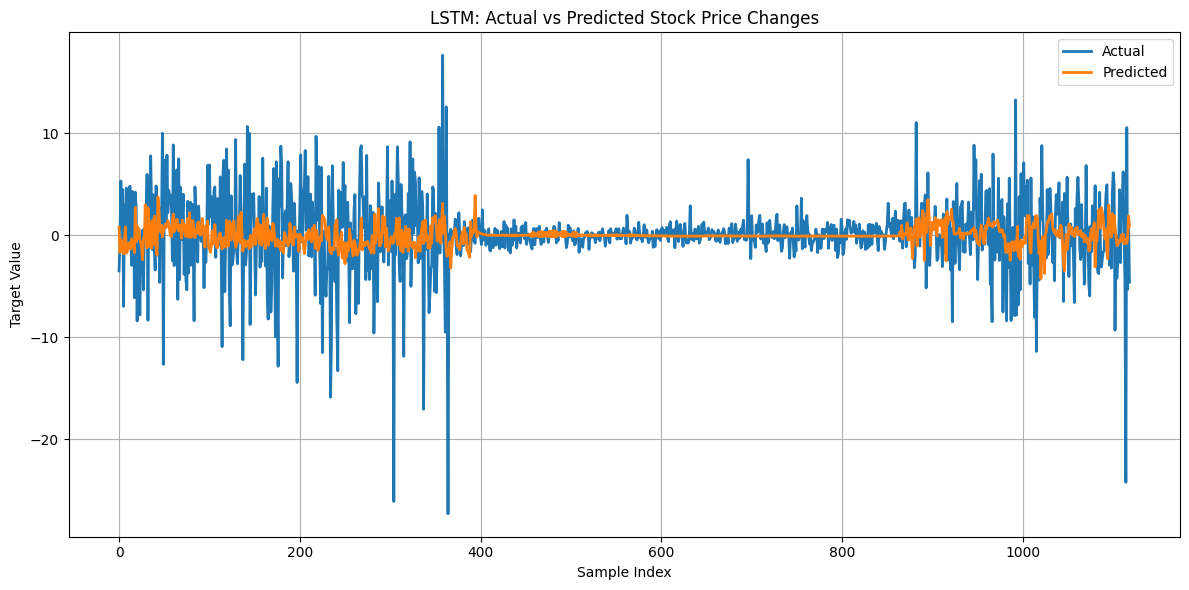

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_clean, label='Actual', linewidth=2)
plt.plot(y_pred_clean, label='Predicted', linewidth=2)
plt.title('LSTM: Actual vs Predicted Stock Price Changes')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

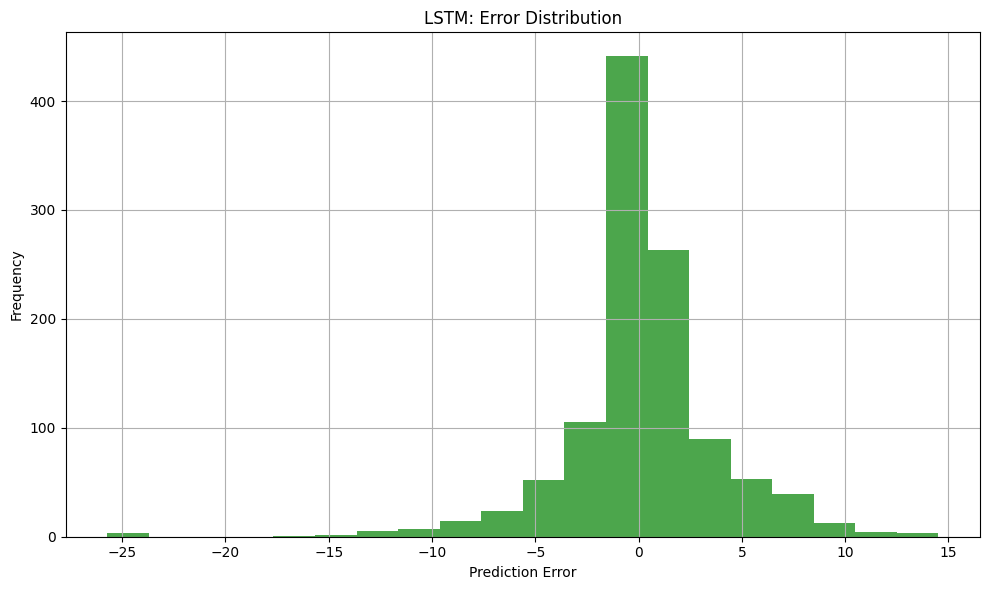

In [76]:
errors = y_test_clean - y_pred_clean
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='green', alpha=0.7)
plt.title("LSTM: Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

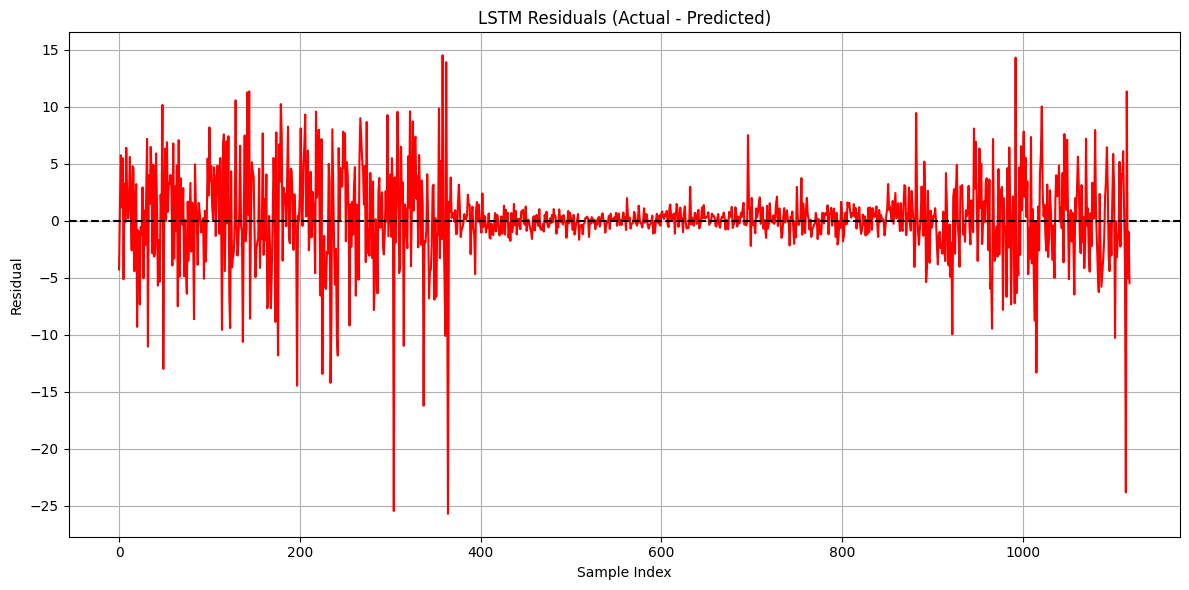

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(errors, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('LSTM Residuals (Actual - Predicted)')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 13.1847 - val_loss: 18.0944
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10.1302 - val_loss: 18.1538
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.9007 - val_loss: 18.1037
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 11.7438 - val_loss: 18.1690
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 10.2918 - val_loss: 18.2186
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 10.1612 - val_loss: 18.1464
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 10.1263 - val_loss: 18.1614
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.4451 - val_loss: 18.3961
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 10.7556 - val_loss: 18.5238
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 10.3620 - val_loss: 18.4606
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 10.8873 - val_loss: 18.6724
Epoch 12/50
112/112 

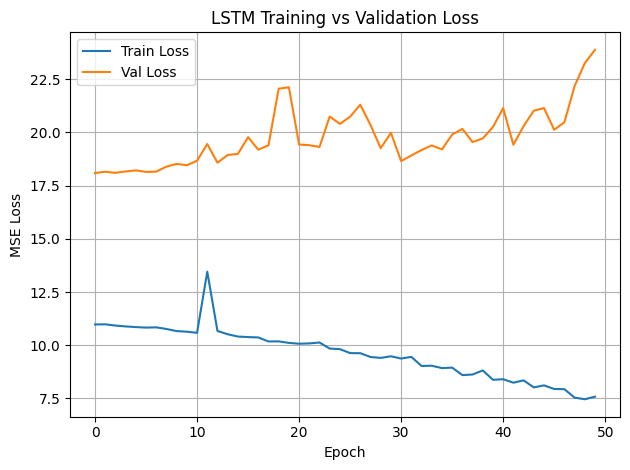

In [ ]:
# Loss Tracker During Training
#history = model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=50, batch_size=32)

#plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Val Loss')
#plt.title('LSTM Training vs Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('MSE Loss')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
